# Kaggle

## 더 좋은 성능을 내기 위해서 하이퍼 파라미터를 수정해야 합니다.

하이퍼 파라미터는 모델 학습을 위해서 사람이 직접 지정해주는 파라미터입니다.

### 먼저 사용할 라이브러리들을 import 합니다.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

### 데이터를 준비합니다.

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### data 컬럼을 보면 T000000이라고 필요 없는 정보가 있습니다.
### 연월 외의 것들은 없애줍시다!
int로 처리해줌으로써 date를 예측을 할 수 있는 특성으로 활용해봅시다.

In [3]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### price 컬럼도 정리합니다.
y 변수에 price를 넣고, train에서 price를 없앱니다.

In [4]:
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


### id 컬럼을 삭제함으로 train data의 전처리를 끝냅니다.

id 컬럼은 필요가 없습니다!

In [5]:
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


### train data에서 했던 것과 같이 test data를 전처리 합니다.

#### date 컬럼에서 연월을 제외한 것들을 없애고,
#### id 컬럼을 지워줍니다.

test data에서 price에 대한 전처리는 하지 않아도 됩니다.

맞춰야 하는 타겟 데이터니까~

In [6]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


#### 타겟 데이터인 y를 확인해봅시다.

In [7]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

### y의 가격 데이터 분포를 확인합시다.

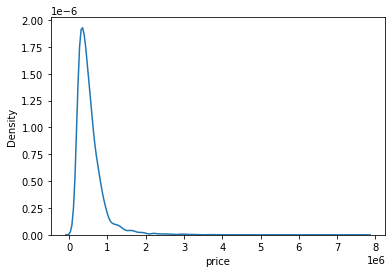

In [8]:
sns.kdeplot(y)
plt.show()

### y의 price data는 한 쪽으로 치우친 형태를 띄고 있는 것을 확인했습니다.

np.log1p() 함수로 로그 변환을 합니다.

나중에 모델이 price의 값을 예측한 다음 다시 np.expml()을 통해 되돌려주겠습니다.

In [9]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

#### 로그 변환을 한 y의 분포를 확인해줍니다.

분포가 고르게 잘 된 것을 알 수 있습니다!

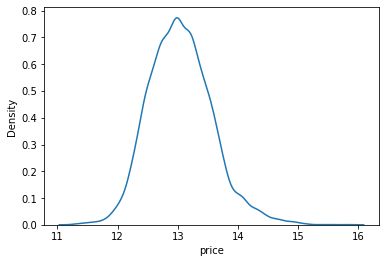

In [10]:
sns.kdeplot(y)
plt.show()

### y의 전체 데이터 자료형을 확인해봅시다.

int와 float 자료형이기에 모델 학습에 활용할 수 있습니다.

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

### RMSE 계산을 합니다.

#### RMSE 계산에 필요한 라이브러리를 불러오고,
#### rmse 함수를 정의합니다.

y_test, y_pred는 로그 변환이 된 값이기에 np.expml()을 추가해서 다시 변환해줍니다.

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

### 사용할 모델을 가져옵니다.

#### XGBRegressor
#### LGBMRegressor
#### GradientBoostingRegressor
#### RandomForestRegressor

모델 인스턴스를 만들어줍니다.

이후 models 리스트에 모델 인스턴스를 넣었습니다.

In [13]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
  
random_state=2020 # 랜덤 시드값

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

클래스의 __name__ 속성에 접근하여 모델의 이름을 출력할 수 있습니다.

In [14]:
print(gboost.__class__.__name__)
print(xgboost.__class__.__name__)
print(lightgbm.__class__.__name__)
print(rdforest.__class__.__name__)

GradientBoostingRegressor
XGBRegressor
LGBMRegressor
RandomForestRegressor


### 모델의 이름에 접근할 수 있기에 for 문에서 각 모델 별 학습을 할 수 있고 예측도 해볼 수 있습니다.

In [15]:
df = {}

for model in models:
    model_name = model.__class__.__name__

    X_train, X_test, y_train, y_test = train_test_split(train, 
                                                        y, 
                                                        random_state=random_state, 
                                                        test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

{'GradientBoostingRegressor': 128360.19649691365,
 'XGBRegressor': 110318.66956616656,
 'LGBMRegressor': 111920.36735892233,
 'RandomForestRegressor': 125487.07102453562}

### 방금 for문으로 수행했던 과정을 함수로 만들었습니다.
#### get_scores(models, train, y)

In [16]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train,
                                                           y,
                                                           random_state=random_state,
                                                           test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
        
        return score_df

### 하이퍼 파라미터 튜닝을 하기 위해서 그리드 탐색을 사용합니다.
#### 그리드 탐색을 사용하기 위해서 라이브러리를 불러옵니다.
#### param_grid에 xgboost 관련 하이퍼 파라미터를 준비합니다.

In [17]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

#### LightGBM 모델을 사용합니다.

In [18]:
model = LGBMRegressor(random_state=random_state)

#### GridSearchCV로 grid_model을 초기화해주고, 
#### grid모델을 train, y로 학습시킵니다.

In [19]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                         scoring='neg_mean_squared_error', \
                         cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

#### 결과는 grid_model.cv_results_ 에 저장되었고 출력해봅니다.

In [20]:
grid_model.cv_results_

{'mean_fit_time': array([0.15471015, 0.22198687, 0.44730129, 0.60838871]),
 'std_fit_time': array([0.05791349, 0.05627203, 0.12307556, 0.08771227]),
 'mean_score_time': array([0.00938215, 0.02168293, 0.01973987, 0.03798108]),
 'std_score_time': array([0.00382782, 0.01737911, 0.00391392, 0.01361282]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'split0_test_score': array([-0.0756974 , -0.05555652, -0.02885847, -0.02665428]),
 'split1_test_score': array([-0.07666447, -0.057876  , -0.03041465, -0.02795896]),
 'split2_test_score': array([-0.07354904

#### 원하는 값인 params와 score만 따로 출력해봅니다.

In [21]:
params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100}]

In [22]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.07339447, -0.05502043, -0.02917734, -0.02702714])

#### 뽑아낸 params와 score로 데이터 프레임을 만듭니다.

In [23]:
results = pd.DataFrame(params)
results['score'] = score

results

,max_depth,n_estimators,score
0,1,50,-0.073394
1,1,100,-0.055020
2,10,50,-0.029177
3,10,100,-0.027027


#### 데이터 프레임에 RMSE를 추가합니다.

음수로 된 MSE이니 -1을 곱하고 np.sqrt로 루트 연산을 합니다.

In [24]:
results['RMSE'] = np.sqrt(-1 * results['score'])
results

,max_depth,n_estimators,score,RMSE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


#### 데이터 프레임에 나온 RMSE 값은 log를 취한 값이기에 RMSLE로 rename 합니다.

In [25]:
results = results.rename(columns={'RMSE': 'RMSLE'})
results

,max_depth,n_estimators,score,RMSLE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


#### RMSLE가 낮은 순서대로 정렬합니다.

In [26]:
results = results.sort_values('RMSLE')
results

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


### 그리드 탐색을 수행하고 결과를 확인하는 과정을 함수로 만듭니다.

In [27]:
"""
다음과 같은 과정을 진행할 수 있는 `my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)` 함수를 구현해 보세요.

1. GridSearchCV 모델로 `model`을 초기화합니다.
2. 모델을 fitting 합니다.
3. params, score에 각 조합에 대한 결과를 저장합니다. 
4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환합니다.
"""

# 코드 입력
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

#### 함수를 사용해서 동일한 결과가 나오는 것을 확인할 수 있습니다.

In [28]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


#### 위의 출력값에서 보면 max_depth=10, n_estimators=100이 가장 좋은 조합입니다.

#### 좋은 조합인 파라미터를 이용해서 모델을 준비하고 학습합니다.

#### 이후 예측 결과를 만듭니다.

In [29]:
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.13580793, 13.08051399, 14.11202067, ..., 13.01592878,
       12.69894979, 12.96297768])

#### 예측 결과에 np.expml() 을 통해 원래 스케일로 돌려줍니다.

In [30]:
prediction = np.expm1(prediction)
prediction

array([ 506766.66784595,  479506.10405112, 1345155.15609376, ...,
        449515.92243642,  327402.87855805,  426332.71354302])

#### sample_submission.csv 파일을 가져옵니다.

In [31]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


#### 위에서 보이는 데이터 프레임에 모델이 예측한 price를 넣어줍시다.

In [32]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.067667e+05
1,15036,4.795061e+05
2,15037,1.345155e+06
3,15038,3.122579e+05
4,15039,3.338645e+05


#### 모델이 예측한 price를 넣은 데이터 프레임을 csv 파일로 저장합니다.

In [33]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.164399.csv


#### 위에서 했던 과정들을 함수로 정리해줍니다.

모델을 학습시키고,

test를 예측합니다.

예측값을 np.expml으로 바꾸고,

csv 파일로 저장합니다.

In [34]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [35]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.0168')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.0168.csv saved!


### LGBMRegressor 모델을 이용한 예측

In [54]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [55]:
param_grid = {
    'n_estimators': [50, 200],
    'max_depth': [1, 20],}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,20,200,-0.026245,0.162003
2,20,50,-0.029198,0.170875
1,1,200,-0.045195,0.212591
0,1,50,-0.073394,0.270914


LGBMRegressor 모델을 사용했을때 하이퍼 파라미터의 값들을 높였을때 RMSLE 값이 더 낮게 나옴을 확인했습니다.


In [56]:
model = LGBMRegressor(max_depth=20, n_estimators=200,random_state=random_state)

save_submission(model, train, y, test, 'lgbm', rmsle='0.162003')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.162003.csv saved!


LGBMRegressor(max_depth=20, n_estimators=200,random_state=random_state)으로 돌렸을 때 나온 결과를 csv로 캐글에 제출하니 

score는 108796.88358이었습니다.

### GradientBoostingRegressor 모델을 이용한 예측

In [36]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],}

model = GradientBoostingRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.029483,0.171707
2,10,50,-0.029899,0.172913
1,1,100,-0.055036,0.234597
0,1,50,-0.073253,0.270653


In [49]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 5],}

model = GradientBoostingRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,5,100,-0.028615,0.169161
2,5,50,-0.031385,0.177158
1,1,100,-0.055036,0.234597
0,1,50,-0.073253,0.270653


GradientBoostingRegressor 모델은 n_estimator의 최대 크기를 높이고 max_depth도 깊게 하니 오히려 RMSLE가 높게 나왔습니다.

max_depth의 깊이를 5로 낮추니 RMSLE가 0.169161로 이전보다 줄어들었음을 확인했습니다.

In [50]:
model = GradientBoostingRegressor(max_depth=5, n_estimators=100,random_state=random_state)

save_submission(model, train, y, test, 'gbr', rmsle='0.169161')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_gbr_RMSLE_0.169161.csv saved!


### XGBRegressor 모델을 이용한 예측

In [57]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],}

model = XGBRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warni

,max_depth,n_estimators,score,RMSLE
2,10,50,-0.030349,0.174210
3,10,100,-0.030470,0.174557
1,1,100,-0.043046,0.207475
0,1,50,-0.048745,0.220782


In [58]:
model = XGBRegressor(max_depth=10, n_estimators=50,random_state=random_state)

save_submission(model, train, y, test, 'xgboost', rmsle='0.174210')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_xgboost_RMSLE_0.174210.csv saved!
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.9s
[CV] END ......................max_depth=1, n_estimators=200; total time=   4.1s
[CV] END ......................max_depth=20, n_estimators=50; total time=  17.5s
[CV] END .....................max_depth=20, n_estimators=200; total time= 1.0min
[CV] END .......................max_depth=1, n_estimators=50; total time=   1.3s
[CV] END ......................max_depth=1, n_estimators=100; total time=   1.8s
[CV] END ......................max_depth=20, n_estimators=50; total time=  15.7s
[CV] END .....................max_depth=20, n_estimators=100; total time=  34.8s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.9s
[CV] END ......................max_depth=1, n_estimators=100; total time=   1.8s
[CV] END .......................max_depth=5, n_estimators=50; total time=   4.8s
[CV] END ...............

XGBRegressor 모델을 사용하니 다른 모델들에 비해서 시간이 너무 오래걸려서 n_estimators': [50, 100],
    'max_depth': [1, 10] 로 돌린 값만 봤습니다.
    
LGBMRegressor 모델의 RMSLE의 값이 훨씬 잘 나와서 더 이상 모델을 돌리지 않았습니다.

### RandomForestRegressor 모델을 이용한 예측

In [43]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],}

model = RandomForestRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.035232,0.187702
2,10,50,-0.035439,0.188252
1,1,100,-0.179128,0.423235
0,1,50,-0.179746,0.423965


In [45]:
model = RandomForestRegressor(max_depth=10, n_estimators=100,random_state=random_state)

save_submission(model, train, y, test, 'rdforest', rmsle='0.187702')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_rdforest_RMSLE_0.187702.csv saved!
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.7s
[CV] END ......................max_depth=1, n_estimators=100; total time=   1.4s
[CV] END ......................max_depth=1, n_estimators=100; total time=   1.5s
[CV] END ......................max_depth=10, n_estimators=50; total time=   5.5s
[CV] END .....................max_depth=10, n_estimators=100; total time=  10.9s
[CV] END .......................max_depth=1, n_estimators=50; total time=   1.4s
[CV] END ......................max_depth=10, n_estimators=50; total time=   6.0s
[CV] END .....................max_depth=10, n_estimators=100; total time=  12.0s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.7s
[CV] END ......................max_depth=1, n_estimators=100; total time=   1.4s
[CV] END ......................max_depth=10, n_estimators=50; total time=   6.8s
[CV] END ..............

RandomRorestRegressor 모델은 같은 하이퍼 파라미터를 지정하고 모델을 돌렸는데 RMSLE가 다른 모델들에 비해서 높게 나와서 그냥 냅뒀습니다.

# 회고

캐글에 도전해 볼 수 있어서 영광이었습니다.

무언가 집 값을 예측한다는 것이 과연 내가 할 수 있는 것일까 하는 생각도 했습니다만 결국 꾸역꾸역 진행을 하니 10만 점대 스코어도 나오더군요.

여러 모델을 학습시키고 결과가 전부 다르게 나오는 점은 좀 흥미로웠습니다.

동일한 하이퍼 파라미터를 지정했는데 어떤 모델은 잘 나오고 어떤 모델은 너무 잘 안나와서 좀 궁금해지기도 했구요.

그러나 BUT 갑자기 난이도가 올라가서 좀 힘들었습니다.

뭔가 광야에 던져진 느낌이랄까요...?

사자가 새끼를 강하게 키우기 위해 새끼를 절벽에서 떨어트린다고 했었나요...?

그런 느낌이겠죠?

그런 이유에서 어려워 진 것이라면 찬성입니다....

갈아넣어보겠어요...

아무튼 화이팅하시고 저도 힘내겠습니다.


### 쉽지 않았다.



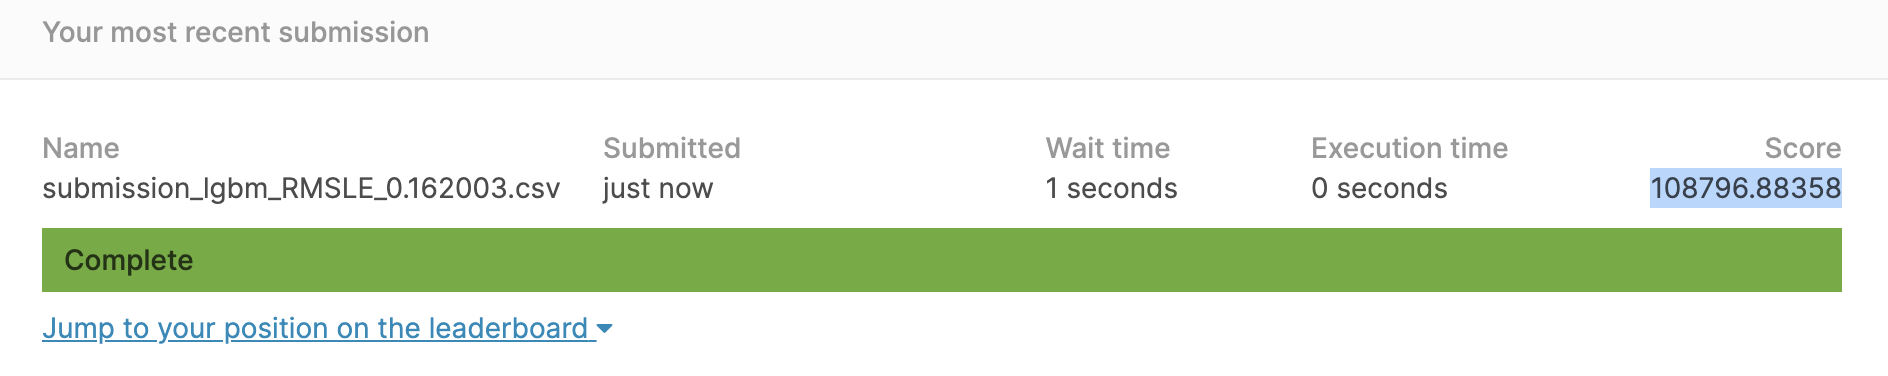